# Filtrage des données

In [1]:
import numpy as np
from pyomeca import Markers
import matplotlib.pyplot as plt

file_path = 'data/PV14_ROM.c3d' 
markers = Markers.from_c3d(file_path)

## Principe du nettoyage des signaux

Dans l'analyse descriptive des mouvements réalisés au cours de ce TP, on va chercher à mesurer des valeurs discrètes, i.e. qui apparaissent ponctuellement au cours de la capture (e.g. Hauteur max) ou qui résument la performance réalisée (e.g. vitesse moyenne, amplitude d'un angle, ...).
Même avec des outils de mesure aussi précis que ceux utilisés, les interprétations peuvent être faussées si l'on travail sur des données brutes qui présentent **du bruit de mesure** (même minime).

Le mouvement est une succession de positions au cours du temps, que l'on peut considérer comme un signal : évolution continue d'un indicateur dans une dimension donnée.
Pour nettoyer un signal, il existe différentes techniques de **lissage** ou de **filtrage**. 
- Le lissage consiste à modéliser mathématiquement le signal, ou une portion du signal, par exemple avec une fonction linéaire ou polynomiale. Très utile pour combler des pertes de données (interpolation). 
- Pour le lissage, il faut considérer un signal étudié comme une somme d'oscillations. Le lissage consiste à exclure les fréquences d'oscillation qui ne correspondent pas aux fréquences naturelles de l'objet d'étude. Dans notre cas, on ne va chercher à conserver que les oscillations associés aux mouvements humains.



### Illustration avec des données bidon

Exemple de la marche, un mouvement typiquement cyclique, avec en moyenne un pas toutes les secondes. Pour étudier cette activité, on pourrait observer la trajectoire sur l'axe vertical d'un marqueur positionné sur la hanche.

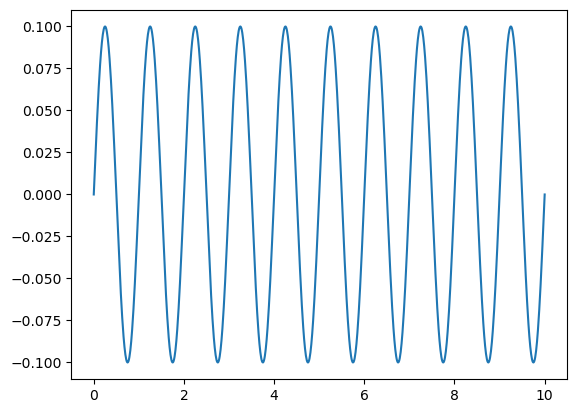

In [2]:
amplitude = 0.1 # valeur arbitraire de l'amplitude des oscillations
freq_step = 1 # nb de pas par seconde 
walk_time = np.linspace(0,10,1000) # vecteur temps de 0 à 10 comprenant 100 valeurs
y_walk = amplitude* np.sin(2*np.pi*walk_time*freq_step) # trajectoire du marqueur sur l'axe vertical

plt.plot(walk_time, y_walk)
plt.show()

La fréquence d'oscillation indique le nombre de fois qu'une variation du signal apparait dans un interval de temps. Dans l'analyse du mouvement humain de ce TP, nous pouvons nous baser sur une fréquence de coupure à 10Hz. 

:::{note}
Cette valeur de 10Hz n'est pertinente que dans notre analyse de la mocap, mais elle est complètement fausse pour d'autres signaux biologiques comme ceux collectés par EMG (pour celles et ceux qui vont travailler avec dans leur mémoire). 
:::

Affichons maintenant un signal qui dépasse les 10Hz et qui pourrait être considéré comme du bruit de mesure.

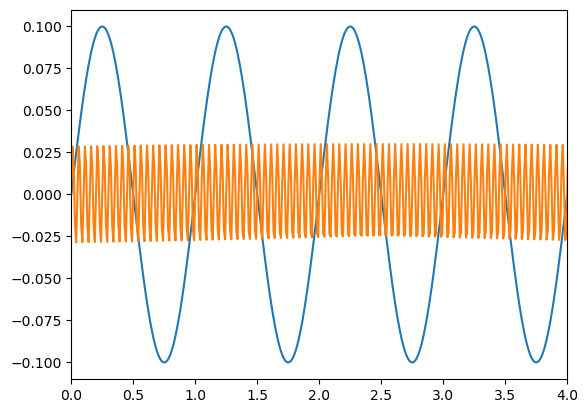

In [3]:
amplitude2 = 0.03 # dépend de l'erreur de mesure par exemple (comme la qualité de votre calibration du système de mocap)
freq_noise = 20 # comme si on réalisait 20 mouvements par seconde...
y2_noise = amplitude2 * np.sin(2*np.pi*walk_time*freq_noise)

plt.plot(walk_time, y_walk)
plt.plot(walk_time, y2_noise)
plt.xlim(0,4)
plt.show()

Maintenant, si on additionne les oscillations du mouvement humain à celle du bruit de mesure.

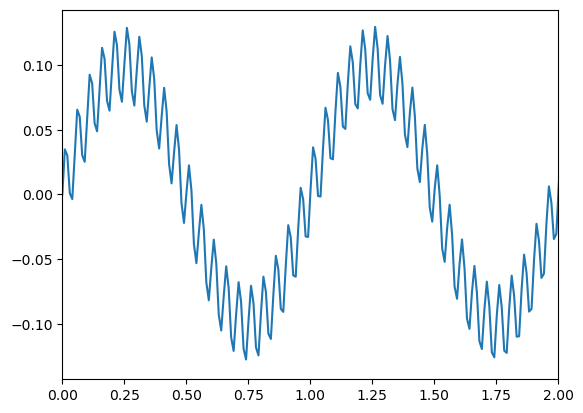

In [4]:
y3_step_noise = y_walk + y2_noise
plt.plot(walk_time, y3_step_noise)
plt.xlim(0,2) # on zoom sur un cycle
plt.show()

Même si cette erreur peut paraitre minime au départ, elle peut engendrer des distorsions importantes lorsque l'on va s'intéresser aux dérivées du signal (vitesse / accélération).

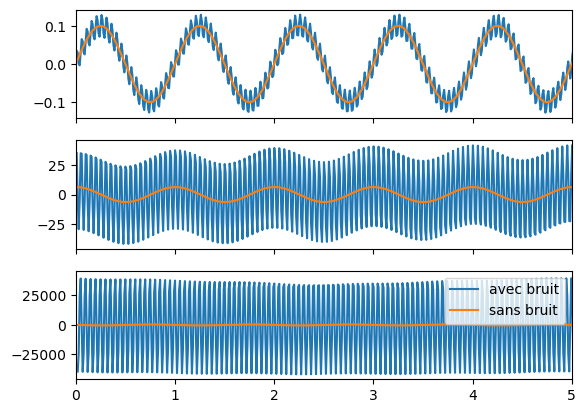

In [5]:
v_walk = np.diff(y_walk)/0.001
a_walk = np.diff(v_walk)/0.001
v3_noise = np.diff(y3_step_noise) / 0.001
a3_noise = np.diff(v3_noise) / 0.001

fig, ax = plt.subplots(3,1, sharex=True)
ax[0].set_xlim(0,5)
ax[0].plot(walk_time, y3_step_noise)
ax[0].plot(walk_time, y_walk)
ax[1].plot(walk_time[1:], v3_noise)
ax[1].plot(walk_time[1:], v_walk)
ax[2].plot(walk_time[2:], a3_noise,label='avec bruit')
ax[2].plot(walk_time[2:], a_walk,label='sans bruit')
plt.legend()
plt.show()

## Filtrage par **pass-band**

Le filtrage *pass-band* vise à exclure les fréquences d'oscillations d'un signal qui sont en dehors d'une *bande* de fréquence considérée.
Dans notre cas, nous allons plus précisément appliquer un filtre *passe-bas* qui ne laisse passer que les fréquences en dessous d'une fréquence de coupure (10Hz). Toutes les fréquences supérieures seront considérées comme du bruit et seront exclues.

Le package **pyomeca** offre directement des fonctions de filtrage pour faciliter le traitement des données (https://pyomeca.github.io/data-processing/). Nous allons utiliser la fonction `low_pass()` pour appliquer un filtre passe-bas dans ce TP (https://pyomeca.github.io/api/dataarray_accessor/#pyomeca.dataarray_accessor.DataArrayAccessor.low_pass).

In [6]:
freq_cutoff= 10
freq = markers.attrs['rate']
rwrb = markers.sel(channel='RWRB', axis=['x','y','z'])
rwrb_filt = rwrb.meca.low_pass(order=2, cutoff=freq_cutoff,freq=100)

:::{note}
Si tableau de *nan*, c'est qu'il manque des données sur certaines portions du mouvement, vérifiez que l'interpolation a été réalisée sur ce marqueur. Dans QTM, le paramètre *fill* d'un label doit bien être à 100%.
Comme solutions, vous pouvez retourner dans QTM pour finir l'interpolation ou appliquer l'instruction `markers = markers.interpolate_na(dim="time", method="cubic")` du package pyomeca pour interpoler ici (mais le résultat sera potentiellement moins qualitatif)
:::

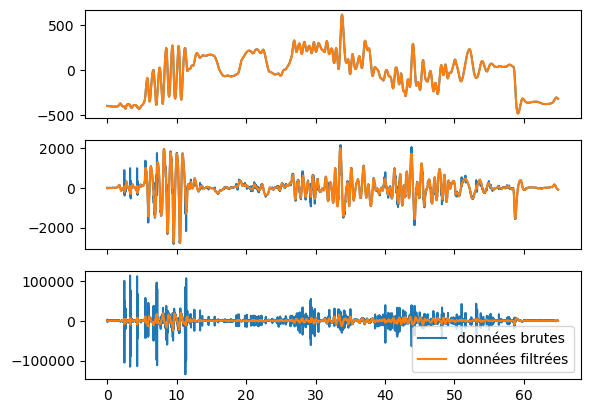

In [7]:
fig, ax = plt.subplots(3,1, sharex=True)
rwrb_x = rwrb.T[:,0]         
rwrb_filt_x = rwrb_filt.T[:,0] 

ax[0].plot(rwrb.time, rwrb_x)
ax[0].plot(rwrb_filt_x.time, rwrb_filt_x)

v_x=np.diff(rwrb_x)/0.01
vfilt_x=np.diff(rwrb_filt_x)/0.01

ax[1].plot(rwrb.time[1:], v_x)
ax[1].plot(rwrb_filt_x.time[1:], vfilt_x)

a_x=np.diff(v_x)/0.01
afilt_x=np.diff(vfilt_x)/0.01

ax[2].plot(rwrb.time[2:], a_x, label='données brutes')
ax[2].plot(rwrb_filt_x.time[2:], afilt_x, label='données filtrées')

plt.legend()
plt.show()

:::{note}
La fonction `meca.low_pass()` peut directement être appliqué sur l'objet `markers`, et non pas sur un unique marqueur, pour filtrer directement la trajectoire de **tous** les marqueurs labélisés de la capture.
:::

In [8]:
markers = markers.meca.low_pass(order=2, cutoff=freq_cutoff,freq=100)